In [1]:
import yaml
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
import numpy as np
import os
import pandas as pd
import json
import scipy
import rasterio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.spatial import distance
from matplotlib.ticker import ScalarFormatter
import math
from scipy.optimize import curve_fit
import cv2
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import ttest_rel
import feather
import yaml
import h5py
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False

In [2]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

# 會用到的函數

In [49]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance

def plot_ellipse(center, covariance, ax, n_std=2.0, facecolor='none', linewidth=2, **kwargs):
    """
    在给定的轴上绘制一个椭圆。

    :param center: 椭圆的中心点。
    :param covariance: 椭圆的协方差矩阵。
    :param ax: matplotlib 轴对象。
    :param n_std: 确定椭圆大小的标准差倍数。
    :param facecolor: 椭圆的填充颜色。
    :param linewidth: 椭圆的线条粗细。
    :param kwargs: 传递给 Ellipse 对象的其他参数。
    """
    # 计算协方差矩阵的特征值和特征向量
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # 计算椭圆的宽度和高度
    width, height = 2 * n_std * np.sqrt(eigenvals)
    angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

    # 创建并添加椭圆形状，使用 linewidth 来调整线条粗细
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, facecolor=facecolor, 
                      linewidth=linewidth, **kwargs)
    ax.add_patch(ellipse)
    
def png_operation(rst):
    grid_normalized = cv2.normalize(rst, None, 0, 255, cv2.NORM_MINMAX)
    grid_uint8 = grid_normalized.astype(np.uint8)
    colored_image = cv2.applyColorMap(grid_uint8, cv2.COLORMAP_JET)
    # 設定要調整的尺寸，例如 300x300
    new_size = (300, 300)
    # 調整 PNG 的大小
    resized_png = cv2.resize(colored_image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_png
# 顯著性標示函式
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'n.s.'
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

env_list_change = {
    'clt': 'Cloud area fraction',
    'hurs': 'Relative humidity',
    'pr': 'Precipitation',
    'rsds': 'Shortwave radiation',
    'sfcWind': 'Wind speed',
    'tas': 'Temperature',
    'EVI': 'EVI',
    'landcover_PC00': 'LandcoverPC1',
    'landcover_PC01': 'LandcoverPC2',
    'landcover_PC02': 'LandcoverPC3',
    'landcover_PC03': 'LandcoverPC4',
    'landcover_PC04': 'LandcoverPC5', 
}

In [57]:
# create a plot folder of the specific exp_id
plot_path = os.path.join('plots', run_id)
plot_path_df = os.path.join(plot_path, 'Fig4_dataframe')
create_folder(plot_path_df)
plot_path_nichespace = os.path.join(plot_path, 'Fig4_niche_space')
create_folder(plot_path_nichespace)
plot_path_nichecomparison = os.path.join(plot_path, 'Fig4_nichecomparison')
create_folder(plot_path_nichecomparison)
plot_path_envcorrelation = os.path.join(plot_path, 'FigS3_envcorrelation')
create_folder(plot_path_envcorrelation)

In [5]:
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
with open(os.path.join(predicts_path, 'DeepSDM_conf.yaml'), 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))

with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

with open(os.path.join(predicts_path, 'env_inf.json'), 'r') as f:
    env_inf = json.load(f)
    
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    extent_binary = f.read(1)

In [6]:
deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [7]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])
date_list_train = DeepSDM_conf.training_conf['date_list_train']
date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
env_list = DeepSDM_conf.training_conf['env_list']

# 使用全部的環境資料來PCA

### 讀取所有的環境資料

In [53]:
df_env = pd.DataFrame()
for date in date_list_train:
    df_date = pd.DataFrame()
    for env in env_list:
        env_path = os.path.join(env_inf['dir_base'], env_inf['info'][env][date]['tif_span_avg'])
        with rasterio.open(env_path, 'r') as f:
            if env in DeepSDM_conf.training_conf['non_normalize_env_list']:
                env_value = (f.read(1))[extent_binary == 1].flatten()
            env_value = ((f.read(1))[extent_binary == 1].flatten() - env_inf['info'][env]['mean']) / env_inf['info'][env]['sd']
        df_date[env] = env_value
    df_env = pd.concat([df_env, df_date], ignore_index = True)

### 檢查環境因子間的相關性

In [54]:
df_env_corr = pd.DataFrame(df_env, columns = env_list).corr()
df_env_corr

,clt,hurs,pr,rsds,sfcWind,tas,EVI,landcover_PC00,landcover_PC01,landcover_PC02,landcover_PC03,landcover_PC04
clt,1.000000,0.646469,0.500409,-0.226728,-0.095269,-0.090187,0.119220,-0.264780,0.053206,0.006893,0.000013,-0.019453
hurs,0.646469,1.000000,0.319188,-0.294080,-0.114281,-0.050017,0.171116,-0.311213,0.038529,-0.024504,-0.022161,-0.055479
pr,0.500409,0.319188,1.000000,0.089246,-0.087093,0.193416,0.207360,-0.142039,0.035729,-0.001112,0.001947,-0.021878
rsds,-0.226728,-0.294080,0.089246,1.000000,-0.168906,0.603617,0.284314,0.159116,-0.038368,-0.012133,-0.011207,0.000866
sfcWind,-0.095269,-0.114281,-0.087093,-0.168906,1.000000,-0.069114,-0.285519,0.262189,-0.074140,-0.025339,-0.078687,0.046396
tas,-0.090187,-0.050017,0.193416,0.603617,-0.069114,1.000000,0.239070,0.442452,-0.014851,0.024852,0.025770,0.026686
EVI,0.119220,0.171116,0.207360,0.284314,-0.285519,0.239070,1.000000,-0.378598,0.110976,-0.018808,-0.031638,-0.296646
landcover_PC00,-0.264780,-0.311213,-0.142039,0.159116,0.262189,0.442452,-0.378598,1.000000,0.011025,0.006705,0.033611,0.025964
landcover_PC01,0.053206,0.038529,0.035729,-0.038368,-0.074140,-0.014851,0.110976,0.011025,1.000000,-0.012799,-0.012977,-0.006009
landcover_PC02,0.006893,-0.024504,-0.001112,-0.012133,-0.025339,0.024852,-0.018808,0.006705,-0.012799,1.000000,0.032908,0.021983


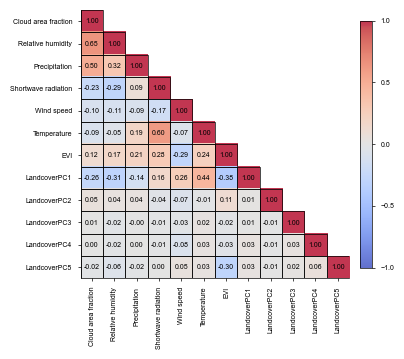

In [64]:
import numpy.ma as ma

# 轉換數據為 NumPy 矩陣
correlation_array = df_env_corr.to_numpy()
sorted_env_factors = df_env_corr.columns

# 建立遮罩：右上三角 (不含對角線) 為 True
mask = np.triu(np.ones_like(correlation_array, dtype=bool), k=1)
# 將 correlation_array 轉為 masked array，遮罩右上三角
masked_corr = ma.array(correlation_array, mask=mask)

# 複製 colormap 並設定遮罩區域為白色
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='white')

# 創建圖表，使用 constrained_layout=True 以符合 B 的版面配置
fig, ax = plt.subplots(figsize=mm2inch(100, 100), constrained_layout=True)

# 顯示矩陣，使用 masked array 與自訂 colormap
cax = ax.imshow(masked_corr, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1, alpha = 0.8)

# 加入 colorbar 作為 legend，調整 fraction 與 pad 參數以取得適合的尺寸
cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cb.ax.tick_params()  # 可調整 colorbar 的字體大小
cb.ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
# 設置坐標標籤
ax.set_xticks(np.arange(len(sorted_env_factors)))
ax.set_yticks(np.arange(len(sorted_env_factors)))
ax.set_xticklabels([env_list_change[i] for i in sorted_env_factors], rotation=90)
ax.set_yticklabels([env_list_change[i] for i in sorted_env_factors])

# 僅在左下三角（包含對角線）中標記數值並繪製框線
for i in range(len(sorted_env_factors)):
    for j in range(len(sorted_env_factors)):
        if i >= j:  # 僅針對左下三角和對角線部分
            # 繪製格線框線
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                 fill=False, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)
            # 在框內標記數值，保留兩位小數
            value = correlation_array[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center',
                    color='black', fontsize=5)

# 隱藏上、右邊框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(plot_path_envcorrelation, 'env_correlation.pdf'),
            dpi=500, transparent=True)
plt.show()


In [10]:
df_env_corr.to_csv(os.path.join(plot_path_df, 'correlation.csv'), index = True)

### PCA 轉換

In [195]:
pca = PCA()
pca.fit(df_env)
df_pca = pca.transform(df_env)

In [196]:
pca.explained_variance_ratio_

array([0.20262002, 0.1650405 , 0.11298901, 0.09268415, 0.08398669,
       0.08181461, 0.07816749, 0.05875113, 0.05068622, 0.03177642,
       0.02571561, 0.01576817])

In [13]:
pd.DataFrame(
    pca.explained_variance_ratio_, 
    columns = ['ratio'], 
    index = [f'PC{i+1:02d}' for i in range(len(df_env.columns))]
).to_csv(
    os.path.join(plot_path_df, 
                 'explained_variance_ratio.csv'), 
    index = True)

In [197]:
df_pca_contribution = pd.DataFrame(pca.components_, columns = [f'PC{i+1:02d}' for i in range(len(df_env.columns))])
df_pca_contribution.index = env_list
df_pca_contribution

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12
clt,0.507393,0.499801,0.348267,-0.205608,-0.197586,-0.168702,0.261908,-0.419345,0.076294,-0.012199,-0.018924,-0.104467
hurs,0.016522,0.037227,-0.252250,-0.569921,0.271183,-0.563281,-0.439267,-0.081774,-0.047743,-0.003727,-0.011332,0.130425
pr,0.354457,0.238046,0.393745,-0.016204,0.325579,0.328194,-0.365290,0.431136,-0.072371,0.047850,0.078699,0.340071
rsds,-0.025807,-0.062756,-0.044548,0.042801,-0.415832,-0.040281,-0.085355,-0.168568,-0.026396,0.380951,0.639266,0.476297
sfcWind,-0.003685,-0.014138,-0.038147,-0.074928,-0.076031,0.000767,-0.018995,0.147936,0.936789,-0.251105,0.075061,0.135751
tas,0.022926,0.003100,-0.015253,-0.109037,0.109336,0.022484,0.038507,0.143545,0.268840,0.871999,-0.154293,-0.310373
EVI,0.031456,0.059635,-0.025030,-0.159046,0.125928,0.022059,0.040657,0.237937,-0.049444,-0.153716,0.708421,-0.605795
landcover_PC00,-0.093933,-0.273236,0.303895,0.130957,0.687332,-0.125492,0.313527,-0.361852,0.110028,0.052044,0.215521,0.168358
landcover_PC01,0.016492,-0.503137,0.634819,0.037088,-0.289580,-0.284332,-0.343449,0.030171,0.017352,-0.027798,-0.060976,-0.232056
landcover_PC02,-0.403196,-0.053169,0.298958,-0.677208,-0.128735,0.195371,0.386906,0.192401,-0.104557,-0.019653,-0.049066,0.177304


In [15]:
df_pca_contribution.to_csv(os.path.join(plot_path_df, 'PCA_weights.csv'), index = True)

### 繪製視覺化的圖

In [198]:
df_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index = env_list, columns = [f'PC{i+1:02d}' for i in range(len(env_list))])
df_loadings.to_csv(os.path.join(plot_path_df, 'PCA_loadings.csv'))
df_loadings

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12
clt,0.791181,0.023251,0.412736,-0.027217,-0.003699,0.022716,0.030466,-0.078871,0.012862,-0.248977,-0.355124,-0.080331
hurs,0.779343,0.052390,0.277185,-0.066183,-0.014193,0.003071,0.057757,-0.229423,-0.392394,-0.032832,0.280744,0.136450
pr,0.543056,-0.354991,0.458484,-0.046981,-0.038296,-0.015114,-0.024241,0.255166,0.495091,0.184609,0.130929,0.054106
rsds,-0.320606,-0.802049,-0.018868,0.045139,-0.075221,-0.108039,-0.154037,0.109958,0.028925,-0.418182,0.066139,0.135275
sfcWind,-0.308097,0.381634,0.379110,-0.438542,-0.076328,0.108335,0.121962,0.577118,-0.225842,-0.079495,0.021079,-0.010790
tas,-0.263058,-0.792704,0.382155,-0.042480,0.000770,0.022278,0.021364,-0.105370,-0.221749,0.120644,0.059487,-0.274320
EVI,0.408395,-0.618180,-0.425350,-0.090017,-0.019069,0.038155,0.039376,0.263253,-0.267853,0.238918,-0.211774,0.125277
landcover_PC00,-0.653888,-0.115080,0.502022,-0.177774,0.148515,0.142231,0.230444,-0.303829,0.023530,0.118810,-0.158831,0.218991
landcover_PC01,0.118967,-0.067189,-0.084270,-0.027837,0.940454,0.266379,-0.047887,0.092385,0.013533,-0.064565,0.048509,-0.022633
landcover_PC02,-0.019021,-0.005245,0.055718,0.401756,-0.252087,0.864017,-0.148875,0.043699,-0.021679,-0.012136,0.011799,0.014034


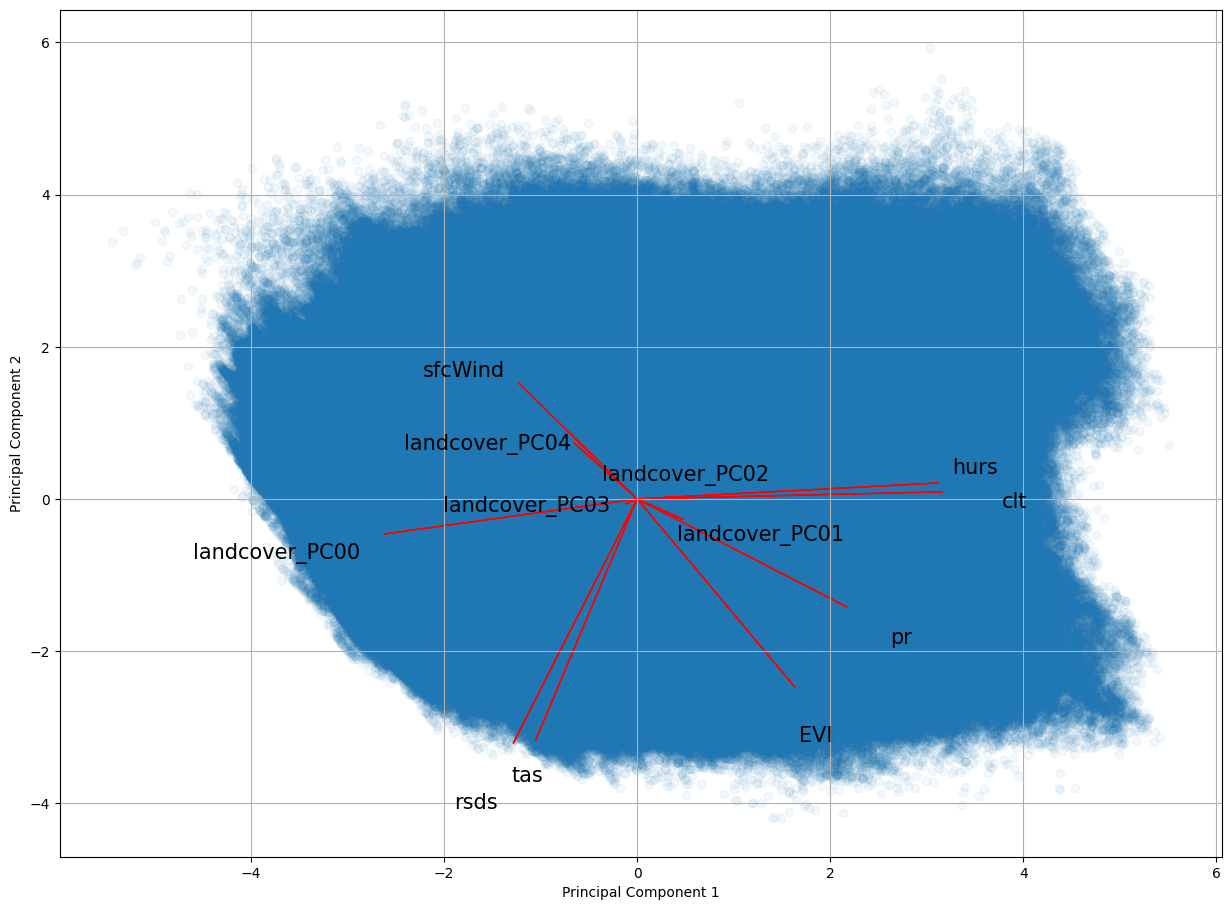

In [16]:
# Extract PCA loadings (contribution of each feature)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_) * 4

# Creating a DataFrame for easier plotting
pca_df = pd.DataFrame(data=df_pca, columns = [f'PC{i+1:02d}' for i in range(len(df_env.columns))])

# Select which PC-axis would be plotted
x_pca = 1
y_pca = 2

# Plotting the PCA results and the loadings
fig = plt.figure(figsize=(15, 11))
plt.scatter(pca_df[f'PC{x_pca:02d}'], pca_df[f'PC{y_pca:02d}'], alpha=0.05)

# Adding loading vectors
text_list = []
for i in range(loadings.shape[0]):
    plt.arrow(0, 0, loadings[i, x_pca-1], loadings[i, y_pca-1], color='r')
    text_list.append(plt.text(loadings[i, x_pca-1]*1.2, loadings[i, y_pca-1]*1.2, f'{env_list[i]}', color='black', ha='center', va='center', fontsize = 15))
adjust_text(text_list)
plt.xlabel(f'Principal Component {x_pca}')
plt.ylabel(f'Principal Component {y_pca}')
plt.title('')
plt.grid(True)
plt.show()
path_out = os.path.join(plot_path_nichespace, f'env_pca.png')
fig.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

In [17]:
for i_env, env in enumerate(env_list):
    print(f'{env:<20}{loadings[i_env, x_pca-1]:>10.2f} {loadings[i_env, y_pca-1]:>10.2f}')

clt                       3.16       0.09
hurs                      3.12       0.21
pr                        2.17      -1.42
rsds                     -1.28      -3.21
sfcWind                  -1.23       1.53
tas                      -1.05      -3.17
EVI                       1.63      -2.47
landcover_PC00           -2.62      -0.46
landcover_PC01            0.48      -0.27
landcover_PC02           -0.08      -0.02
landcover_PC03           -0.12      -0.06
landcover_PC04           -0.65       0.73


### 儲存所有時間點每格的環境值及PCA降維後各軸數值

In [18]:
# Initialize final DataFrame
df_env_value = []

# Load all raster data once and process
for date in date_list_train:
    print(f'\rProcessing date: {date}', end='')
    env_data = []
    original_col_names = []  # Temporary column names
    final_col_names = []     # Column names for final save

    for env in env_list:
        # Construct file path for raster
        env_path = os.path.join(env_inf['dir_base'], env_inf['info'][env][date]['tif_span_avg'])

        # Load raster data
        with rasterio.open(env_path, 'r') as f:
            raster_data = f.read(1)[extent_binary == 1].flatten()

        # Normalize environmental data
        if env not in DeepSDM_conf.training_conf['non_normalize_env_list']:
            raster_data = (raster_data - env_inf['info'][env]['mean']) / env_inf['info'][env]['sd']

        env_data.append(raster_data)
        original_col_names.append(f'{env}')  # Temporary name
        final_col_names.append(f'{env}_{date}')  # Final name

    # Combine all environmental variables into a single DataFrame with temporary names
    df_season = pd.DataFrame(np.array(env_data).T, columns=original_col_names)

    # Apply PCA to the entire batch
    df_pca = pd.DataFrame(
        data=pca.transform(df_season), 
        columns=[f'PC{i+1:02d}_{date}' for i in range(len(pca.components_))]
    )

    # Rename columns to final names for saving
    df_season.columns = final_col_names

    # Append processed data to the list
    df_env_value.append(pd.concat([df_season, df_pca], axis=1))

# Combine all results into a single DataFrame
df_env_value = pd.concat(df_env_value, axis=1, ignore_index=False)

# Save DataFrame to CSV
output_path = os.path.join(plot_path_df, 'env_value.feather')
feather.write_dataframe(df_env_value, output_path)

print("\nProcessing complete. File saved.")

Processing date: 2018-12-01
Processing complete. File saved.


### 儲存各個物種各別的csv，包含兩個模型的預測值及實際出現點位

In [19]:
# # read the feather file
# df_env_value = feather.read_dataframe(os.path.join(plot_path_df, 'env_value.feather'))

In [21]:
# Function to process a single species
def process_species(species):
    print(f'Processing: {species}')
    series_dict = {}

    # Maxent all_all prediction
    maxent_h5_species_path = maxent_h5_path.replace('[SPECIES]', species)
    if os.path.exists(maxent_h5_species_path):
        with h5py.File(maxent_h5_species_path, 'r') as hf:
            maxent_all_all_value = (hf['all'][:])[extent_binary == 1].flatten()
            series_dict[f'maxent_all_all_{species}'] = maxent_all_all_value

    # Process predictions for all dates
    for date in date_list_predict:
        # DeepSDM continuous prediction (all_season)
        deepsdm_h5_species_path = deepsdm_h5_path.replace('[SPECIES]', species)
        if os.path.exists(deepsdm_h5_species_path):
            with h5py.File(deepsdm_h5_species_path, 'r') as hf:
                deepsdm_all_season_value = (hf[date][:])[extent_binary == 1].flatten()
                series_dict[f'deepsdm_all_season_{species}_{date}'] = deepsdm_all_season_value

        # Maxent continuous prediction (all_season)
        if os.path.exists(maxent_h5_species_path):
            with h5py.File(maxent_h5_species_path, 'r') as hf:
                maxent_all_season_value = (hf[date][:])[extent_binary == 1].flatten()
                series_dict[f'maxent_all_season_{species}_{date}'] = maxent_all_season_value

        # Occurrence points
        occ_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][date])
        if os.path.exists(occ_path):
            with rasterio.open(occ_path, 'r') as f:
                occ_value = (f.read(1))[extent_binary == 1].flatten()
                series_dict[f'occ_{species}_{date}'] = occ_value.astype(int)
        
    # Combine all data into a single DataFrame
    df_species = pd.DataFrame(series_dict)

    # Save to .feather file
    output_path = os.path.join(plot_path_df, f'{species}.feather')
    feather.write_dataframe(df_species, output_path)
    print(f'Finished: {species}')

# Parallelize processing for all species
with ThreadPoolExecutor(max_workers=32) as executor:  # Adjust max_workers based on CPU cores
    executor.map(process_species, species_list_predict)

print("All species processed successfully!")


Processing: Abroscopus_albogularis
Processing: Accipiter_trivirgatus
Processing: Accipiter_virgatus
Processing: Acridotheres_cristatellus
Processing: Actinodura_morrisoniana
Processing: Aegithalos_concinnus
Processing: Alauda_gulgula
Processing: Alcippe_brunnea
Processing: Alcippe_morrisonia
Processing: Amaurornis_phoenicurus
Processing: Apus_nipalensis
Processing: Arborophila_crudigularis
Processing: Bambusicola_sonorivox
Processing: Brachypteryx_goodfellowi
Processing: Caprimulgus_affinis
Processing: Carpodacus_formosanus
Processing: Cecropis_striolata
Processing: Centropus_bengalensis
Processing: Chalcophaps_indica
Processing: Cinclus_pallasii
Processing: Cisticola_exilis
Processing: Cisticola_juncidis
Processing: Columba_pulchricollis
Processing: Coracina_macei
Processing: Corvus_macrorhynchos
Processing: Delichon_dasypus
Processing: Dendrocitta_formosae
Processing: Dendrocopos_leucotos
Processing: Dicaeum_ignipectus
Processing: Dicaeum_minullum
Processing: Dicrurus_aeneus
Processi

In [154]:
dd = feather.read_dataframe('./plots/e52c8ac9a3e24c75ac871f63bbdea060/hypervolume/Abroscopus_albogularis.feather')

In [164]:
dd

,pc01_occ,pc02_occ,pc03_occ,pc01_maxent,pc02_maxent,pc03_maxent,pc01_deepsdm,pc02_deepsdm,pc03_deepsdm,date
0,1.413527,2.513535,0.522623,-2.289162,0.596738,-1.877908,-1.368312,0.724338,-2.568516,2009-01-01
1,0.023142,1.683061,-1.477217,-2.967534,1.158180,-0.453836,-0.825451,1.728395,-2.199907,2009-01-01
2,-1.601871,2.130243,-2.128978,-2.516868,0.257279,-1.681868,1.206142,1.582347,-0.939207,2009-01-01
3,-2.412235,1.481343,-1.539817,-2.315547,0.285947,-2.462649,-0.272942,1.142670,-1.924432,2009-01-01
4,-4.607463,3.813876,-1.831879,-2.838232,0.425230,-1.810883,-1.626699,0.648638,-2.701707,2009-01-01
...,...,...,...,...,...,...,...,...,...,...
6720,-0.004423,0.558995,-1.901307,1.680570,0.778280,0.619022,-1.440980,1.457898,-2.212395,2018-12-01
6721,-0.332873,1.512427,-1.187244,1.991400,1.130327,0.200917,-1.309093,0.686925,-2.224676,2018-12-01
6722,0.068414,0.229182,-1.875432,-0.298543,2.088119,1.652733,-0.723094,1.662910,-1.752708,2018-12-01
6723,-0.290310,0.119899,-1.882311,2.364887,0.449848,-0.344826,-0.426838,-0.163246,-2.055718,2018-12-01


### 計算各種類型的資訊

In [58]:
niche_rst_size = 100

# 各個pc軸的最大值與最小值
pc_info = dict(
    **{
        f'PC{(n_pc+1):02d}_max': df_env_value.loc[:, df_env_value.columns.str.startswith(f'PC{(n_pc+1):02d}')].max().max().tolist() for n_pc in range(len(env_list))
    }, 
    **{
        f'PC{(n_pc+1):02d}_min': df_env_value.loc[:, df_env_value.columns.str.startswith(f'PC{(n_pc+1):02d}')].min().min().tolist() for n_pc in range(len(env_list))
    }
)

# 各個pc軸的切割raster資訊
bin_info = {
    f'PC{(n_pc+1):02d}_bins': np.linspace(pc_info[f'PC{(n_pc+1):02d}_min'], pc_info[f'PC{(n_pc+1):02d}_max'], num = niche_rst_size + 1) for n_pc in range(len(env_list))
}
bin_info_list = {key: bin_info[key].tolist() for key in bin_info}

# 切割完raster後的extent資訊
extent_info = dict(
    **{
        f'PC{(n_pc+1):02d}_extent_max': ((bin_info[f'PC{(n_pc+1):02d}_bins'][1:] + bin_info[f'PC{(n_pc+1):02d}_bins'][:-1])/2)[-1].tolist() for n_pc in range(len(env_list))
    }, 
    **{
        f'PC{(n_pc+1):02d}_extent_min': ((bin_info[f'PC{(n_pc+1):02d}_bins'][1:] + bin_info[f'PC{(n_pc+1):02d}_bins'][:-1])/2)[0].tolist() for n_pc in range(len(env_list))
    }
)

df_grid = pd.DataFrame()
for n_pc in range(len(env_list)):
    df_env_value_pc = df_env_value.filter(regex=f'^PC{(n_pc+1):02d}')

    def apply_cut(column):
        return pd.cut(column, 
                      bins=bin_info[f'PC{(n_pc+1):02d}_bins'], 
                      labels=False, 
                      include_lowest=True)

    grid = df_env_value_pc.apply(apply_cut)
    grid.columns = [f'{col}_grid' for col in grid.columns]
    
    df_grid = pd.concat([df_grid, grid], axis=1)

In [59]:
# with open(os.path.join(plot_path_df, 'pc_info.yaml'), 'w') as yaml_file:
#     yaml.dump(pc_info, yaml_file)
# with open(os.path.join(plot_path_df, 'bin_info.yaml'), 'w') as yaml_file:
#     yaml.dump(bin_info_list, yaml_file)
# with open(os.path.join(plot_path_df, 'extent_info.yaml'), 'w') as yaml_file:
#     yaml.dump(extent_info, yaml_file)
# feather.write_dataframe(df_grid, os.path.join(plot_path_df, 'df_grid.feather'))

### 各個預測圖沒有平均至總和為1
- 如果有存下來可以直接讀取資訊

In [63]:
df_grid = feather.read_dataframe(os.path.join(plot_path_df, 'df_grid.feather'))
with open(os.path.join(plot_path_df, 'extent_info.yaml'), 'r') as yaml_file:
    extent_info = yaml.load(yaml_file, Loader=yaml.FullLoader)
df_env_value = feather.read_dataframe(os.path.join(plot_path_df, 'env_value.feather'))

In [96]:
# Select which PC-axis would be plotted
x_pca = 1
y_pca = 2
extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
          extent_info[f'PC{x_pca:02d}_extent_max'], 
          extent_info[f'PC{y_pca:02d}_extent_min'], 
          extent_info[f'PC{y_pca:02d}_extent_max']]

df_spearman = pd.DataFrame({'model': [], 'species': [], 'rho': [], 'p': []})


for species in species_list_predict:
#     sp = 'Picus_canus'

    plot_path_nichespace_png_sp = os.path.join(plot_path_nichespace, 'png', species)
    create_folder(plot_path_nichespace_png_sp)
    plot_path_nichespace_h5 = os.path.join(plot_path_nichespace, 'h5')
    create_folder(plot_path_nichespace_h5)
    
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))
    df_species = pd.concat([df_species, df_grid], axis = 1)
    
    # season
    season_sp_date = [(species, d) for d in date_list_predict]
    grid_deepsdm_all_season_sum = np.zeros((niche_rst_size, niche_rst_size))
    grid_deepsdm_all_season_count = np.zeros((niche_rst_size, niche_rst_size))
    grid_deepsdm_all_season_max = np.zeros((niche_rst_size, niche_rst_size))
    grid_maxent_all_season_sum = np.zeros((niche_rst_size, niche_rst_size))
    grid_maxent_all_season_count = np.zeros((niche_rst_size, niche_rst_size))
    grid_maxent_all_season_max = np.zeros((niche_rst_size, niche_rst_size))
    for (sp, d) in season_sp_date:
        
        # calculate grid values
        grouped = df_species.groupby([f'PC{x_pca:02d}_{d}_grid', f'PC{y_pca:02d}_{d}_grid'])
        
        # deepsdm all_season
        grid_deepsdm_all_season_sum_d = np.zeros((niche_rst_size, niche_rst_size))
        grid_deepsdm_all_season_count_d = np.zeros((niche_rst_size, niche_rst_size))
        grid_deepsdm_all_season_max_d = np.zeros((niche_rst_size, niche_rst_size))
                                                 
        try:
            max_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{sp}_{d}'].max()
            sum_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{sp}_{d}'].sum()
            mean_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{sp}_{d}'].mean()
            count_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{sp}_{d}'].count()
            for (x, y), value in max_values_deepsdm_all_season.items():
                grid_deepsdm_all_season_max_d[niche_rst_size-1-y, x] = value
            for (x, y), value in count_values_deepsdm_all_season.items():
                grid_deepsdm_all_season_count_d[niche_rst_size-1-y, x] = value
            for (x, y), value in sum_values_deepsdm_all_season.items():
                grid_deepsdm_all_season_sum_d[niche_rst_size-1-y, x] = value                                                 
        except KeyError:
            pass
        grid_deepsdm_all_season_max = np.nanmax([grid_deepsdm_all_season_max, grid_deepsdm_all_season_max_d], axis = 0)
        grid_deepsdm_all_season_count = grid_deepsdm_all_season_count + grid_deepsdm_all_season_count_d
        grid_deepsdm_all_season_sum = grid_deepsdm_all_season_sum + grid_deepsdm_all_season_sum_d
    
    
    
        # maxent all_season
        grid_maxent_all_season_sum_d = np.zeros((niche_rst_size, niche_rst_size))
        grid_maxent_all_season_count_d = np.zeros((niche_rst_size, niche_rst_size))
        grid_maxent_all_season_max_d = np.zeros((niche_rst_size, niche_rst_size))
        try:
            max_values_maxent_all_season = grouped[f'maxent_all_season_{sp}_{d}'].max()
            sum_values_maxent_all_season = grouped[f'maxent_all_season_{sp}_{d}'].sum()
            mean_values_maxent_all_season = grouped[f'maxent_all_season_{sp}_{d}'].mean()
            count_values_maxent_all_season = grouped[f'maxent_all_season_{sp}_{d}'].count()
            for (x, y), value in max_values_maxent_all_season.items():
                grid_maxent_all_season_max_d[niche_rst_size-1-y, x] = value
            for (x, y), value in count_values_maxent_all_season.items():
                grid_maxent_all_season_count_d[niche_rst_size-1-y, x] = value
            for (x, y), value in sum_values_maxent_all_season.items():
                grid_maxent_all_season_sum_d[niche_rst_size-1-y, x] = value                                                 
        except KeyError:
            pass
        grid_maxent_all_season_max = np.nanmax([grid_maxent_all_season_max, grid_maxent_all_season_max_d], axis = 0)
        grid_maxent_all_season_count = grid_maxent_all_season_count + grid_maxent_all_season_count_d
        grid_maxent_all_season_sum = grid_maxent_all_season_sum + grid_maxent_all_season_sum_d
    
    
    grid_maxent_all_season_count = np.where(grid_maxent_all_season_count == 0, 1, grid_maxent_all_season_count)
    grid_deepsdm_all_season_count = np.where(grid_deepsdm_all_season_count == 0, 1, grid_deepsdm_all_season_count)
                                                
    grid_deepsdm_all_season_mean = grid_deepsdm_all_season_sum / grid_deepsdm_all_season_count
    grid_maxent_all_season_mean = grid_maxent_all_season_sum / grid_maxent_all_season_count

    cv2.imwrite(os.path.join(plot_path_nichespace_png_sp, f'{species}_deepsdm_all_season_nichespace_max.png'), png_operation(grid_deepsdm_all_season_max))
    cv2.imwrite(os.path.join(plot_path_nichespace_png_sp, f'{species}_deepsdm_all_season_nichespace_mean.png'), png_operation(grid_deepsdm_all_season_mean))
    cv2.imwrite(os.path.join(plot_path_nichespace_png_sp, f'{species}_deepsdm_all_season_nichespace_sum.png'), png_operation(grid_deepsdm_all_season_sum))
                                                
    cv2.imwrite(os.path.join(plot_path_nichespace_png_sp, f'{species}_maxent_all_season_nichespace_max.png'), png_operation(grid_maxent_all_season_max))
    cv2.imwrite(os.path.join(plot_path_nichespace_png_sp, f'{species}_maxent_all_season_nichespace_mean.png'), png_operation(grid_maxent_all_season_mean))
    cv2.imwrite(os.path.join(plot_path_nichespace_png_sp, f'{species}_maxent_all_season_nichespace_sum.png'), png_operation(grid_maxent_all_season_sum))
    
    
    logh5_info = {'deepsdm_all_season_max': grid_deepsdm_all_season_max, 
                  'deepsdm_all_season_mean': grid_deepsdm_all_season_mean, 
                  'deepsdm_all_season_sum': grid_deepsdm_all_season_sum, 
                  'maxent_all_season_max': grid_maxent_all_season_max, 
                  'maxent_all_season_mean': grid_maxent_all_season_mean,   
                  'maxent_all_season_sum': grid_maxent_all_season_sum}
    for key, data in logh5_info.items():
        with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'a') as hf:
            if key in hf:
                del hf[key]
            hf.create_dataset(key, data = data)

#     # all
#     # calculate grid values
#     grouped = df_species.groupby([f'PC{x_pca:02d}_grid', f'PC{y_pca:02d}_grid'])

#     # maxent all_all
#     grid_maxent_all_all_mean = np.zeros((niche_rst_size, niche_rst_size))
#     grid_maxent_all_all_sum = np.zeros((niche_rst_size, niche_rst_size))
#     grid_maxent_all_all_max = np.zeros((niche_rst_size, niche_rst_size))
                                   
#     try:
#         mean_values_maxent_all_all = grouped[f'maxent_all_all_{species}'].mean()
#         sum_values_maxent_all_all = grouped[f'maxent_all_all_{species}'].sum()
#         max_values_maxent_all_all = grouped[f'maxent_all_all_{species}'].max()

#         for (x, y), value in mean_values_maxent_all_all.items():
#             grid_maxent_all_all_mean[niche_rst_size-1-y, x] = value
#         for (x, y), value in sum_values_maxent_all_all.items():
#             grid_maxent_all_all_sum[niche_rst_size-1-y, x] = value
#         for (x, y), value in max_values_maxent_all_all.items():
#             grid_maxent_all_all_max[niche_rst_size-1-y, x] = value
#     except KeyError:
#         pass
#     cv2.imwrite(os.path.join(plot_path_nichespace, f'{sp}_maxent_all_all_nichespace_max.tif'), grid_maxent_all_all_max)
#     cv2.imwrite(os.path.join(plot_path_nichespace, f'{sp}_maxent_all_all_nichespace_max.png'), png_operation(grid_maxent_all_all_max))
#     cv2.imwrite(os.path.join(plot_path_nichespace, f'{sp}_maxent_all_all_nichespace_mean.tif'), grid_maxent_all_all_mean)
#     cv2.imwrite(os.path.join(plot_path_nichespace, f'{sp}_maxent_all_all_nichespace_mean.png'), png_operation(grid_maxent_all_all_mean))
#     cv2.imwrite(os.path.join(plot_path_nichespace, f'{sp}_maxent_all_all_nichespace_sum.tif'), grid_maxent_all_all_sum)
#     cv2.imwrite(os.path.join(plot_path_nichespace, f'{sp}_maxent_all_all_nichespace_sum.png'), png_operation(grid_maxent_all_all_sum))


    pcaxy = {'x': list(), 'y': list()}
    for d in date_list_train:
        if f'occ_{species}_{d}' in df_species:
            i_p = df_species[f'occ_{species}_{d}'] == 1
            pcaxy['x'] = pcaxy['x'] + list(df_env_value[f'PC{x_pca:02d}_{d}'][i_p])
            pcaxy['y'] = pcaxy['y'] + list(df_env_value[f'PC{y_pca:02d}_{d}'][i_p])
                                                
    if len(pcaxy['x']) <= 2:
        continue
    center, covariance = cov_center(np.column_stack((pcaxy['x'], pcaxy['y'])), level=0.95)

    # calculate the negative regression of every cell of 2d-niche space to the niche center
    # 计算每个单元格的宽度和高度
    cell_width = (extent[1] - extent[0]) / niche_rst_size
    cell_height = (extent[3] - extent[2]) / niche_rst_size

    # 遍历每个单元格以计算中心点坐标
    coordinates_values = {'center_x': [], 'center_y': [], 'value_maxent_all_season_sum': [], 'value_deepsdm_all_season_sum': [], 
                          'value_maxent_all_season_mean': [], 'value_deepsdm_all_season_mean': [], 
                          'value_maxent_all_season_max': [], 'value_deepsdm_all_season_max': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  #center_x
            coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2) # center_y
            coordinates_values['value_maxent_all_season_sum'].append(grid_maxent_all_season_sum[i, j]) 
            coordinates_values['value_deepsdm_all_season_sum'].append(grid_deepsdm_all_season_sum[i, j])
            coordinates_values['value_maxent_all_season_mean'].append(grid_maxent_all_season_mean[i, j]) 
            coordinates_values['value_deepsdm_all_season_mean'].append(grid_deepsdm_all_season_mean[i, j])
            coordinates_values['value_maxent_all_season_max'].append(grid_maxent_all_season_max[i, j]) 
            coordinates_values['value_deepsdm_all_season_max'].append(grid_deepsdm_all_season_max[i, j])
#             coordinates_values['value_maxent_all_all_sum'].append(grid_maxent_all_all_sum[i, j]) 
#             coordinates_values['value_maxent_all_all_mean'].append(grid_maxent_all_all_mean[i, j]) 
#             coordinates_values['value_maxent_all_all_max'].append(grid_maxent_all_all_max[i, j]) 

    df_cor = pd.DataFrame(coordinates_values).query('value_deepsdm_all_season_sum > 0').reset_index(drop = True)

    df_cor_only = df_cor.loc[df_cor['value_deepsdm_all_season_sum'] > 0, ['center_x', 'center_y']].reset_index(drop = True)

    # 假設這是整個數據集的協方差矩陣
    cov_matrix = np.cov(df_cor_only, rowvar=False)

    # 計算協方差矩陣的逆矩陣
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # 計算 Mahalanobis 距離
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)

                                                
    rho_maxent_all_season_sum, p_maxent_all_season_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_sum'])
    rho_deepsdm_all_season_sum, p_deepsdm_all_season_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_deepsdm_all_season_sum'])
    rho_maxent_all_season_mean, p_maxent_all_season_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_mean'])
    rho_deepsdm_all_season_mean, p_deepsdm_all_season_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_deepsdm_all_season_mean'])
    rho_maxent_all_season_max, p_maxent_all_season_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_max'])
    rho_deepsdm_all_season_max, p_deepsdm_all_season_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_deepsdm_all_season_max'])
#     rho_maxent_all_all_sum, p_maxent_all_all_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_all_sum'])
#     rho_maxent_all_all_mean, p_maxent_all_all_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_all_mean'])
#     rho_maxent_all_all_max, p_maxent_all_all_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_all_max'])
                                                
    # log the regression information
    df_spearman.loc[len(df_spearman)] = ['maxent_sum', species, rho_maxent_all_season_sum, p_maxent_all_season_sum]
    df_spearman.loc[len(df_spearman)] = ['deepsdm_sum', species, rho_deepsdm_all_season_sum, p_deepsdm_all_season_sum]
    df_spearman.loc[len(df_spearman)] = ['maxent_mean', species, rho_maxent_all_season_mean, p_maxent_all_season_mean]
    df_spearman.loc[len(df_spearman)] = ['deepsdm_mean', species, rho_deepsdm_all_season_mean, p_deepsdm_all_season_mean]
    df_spearman.loc[len(df_spearman)] = ['maxent_max', species, rho_maxent_all_season_max, p_maxent_all_season_max]
    df_spearman.loc[len(df_spearman)] = ['deepsdm_max', species, rho_deepsdm_all_season_max, p_deepsdm_all_season_max]
#     df_spearman.loc[len(df_spearman)] = ['value_maxent_all_all_sum', species, rho_maxent_all_all_sum, p_maxent_all_all_sum]
#     df_spearman.loc[len(df_spearman)] = ['value_maxent_all_all_mean', species, rho_maxent_all_all_mean, p_maxent_all_all_mean]
#     df_spearman.loc[len(df_spearman)] = ['value_maxent_all_all_max', species, rho_maxent_all_all_max, p_maxent_all_all_max]
    
    df_spearman.to_csv(os.path.join(plot_path_nichespace, 'spearman_info.csv'), index = False)


/tmp/ipykernel_1402388/712799574.py:187: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_maxent_all_season_sum, p_maxent_all_season_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_sum'])
/tmp/ipykernel_1402388/712799574.py:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_maxent_all_season_mean, p_maxent_all_season_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_mean'])
/tmp/ipykernel_1402388/712799574.py:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_maxent_all_season_max, p_maxent_all_season_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_max'])


### 如果已經有存好的tif，直接讀取然後再計算

In [22]:
# # Select which PC-axis would be plotted
# x_pca = 1
# y_pca = 2
# extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
#           extent_info[f'PC{x_pca:02d}_extent_max'], 
#           extent_info[f'PC{y_pca:02d}_extent_min'], 
#           extent_info[f'PC{y_pca:02d}_extent_max']]
# niche_rst_size = 100
# df_spearman = pd.DataFrame({'model': [], 'species': [], 'rho': [], 'p': []})

# for species in species_list_predict:
#     print(f'\r{species}', end = '')
#     df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))
#     df_species = pd.concat([df_species, df_grid], axis = 1)
    
#     with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
#         grid_deepsdm_all_season_max = hf['deepsdm_all_seaon_max'][:]
#         grid_deepsdm_all_season_mean = hf['deepsdm_all_seaon_mean'][:]
#         grid_deepsdm_all_season_sum = hf['deepsdm_all_seaon_sum'][:]
#         grid_maxent_all_season_max = hf['maxent_all_seaon_max'][:]
#         grid_maxent_all_season_mean = hf['maxent_all_seaon_mean'][:]
#         grid_maxent_all_season_sum = hf['maxent_all_seaon_sum'][:]
                                                
#     pcaxy = {'x': list(), 'y': list()}
#     for d in date_list_train:
#         if f'occ_{species}_{d}' in df_species:
#             i_p = df_species[f'occ_{species}_{d}'] == 1
#             pcaxy['x'] = pcaxy['x'] + list(df_env_value[f'PC{x_pca:02d}_{d}'][i_p])
#             pcaxy['y'] = pcaxy['y'] + list(df_env_value[f'PC{y_pca:02d}_{d}'][i_p])
                                                
#     if len(pcaxy['x']) <= 2:
#         continue
#     center, covariance = cov_center(np.column_stack((pcaxy['x'], pcaxy['y'])), level=0.95)

#     # calculate the negative regression of every cell of 2d-niche space to the niche center
#     # 计算每个单元格的宽度和高度
#     cell_width = (extent[1] - extent[0]) / niche_rst_size
#     cell_height = (extent[3] - extent[2]) / niche_rst_size

#     # 遍历每个单元格以计算中心点坐标
#     coordinates_values = {'center_x': [], 'center_y': [], 'value_maxent_all_season_sum': [], 'value_deepsdm_all_season_sum': [], 
#                           'value_maxent_all_season_mean': [], 'value_deepsdm_all_season_mean': [], 
#                           'value_maxent_all_season_max': [], 'value_deepsdm_all_season_max': []}
#     for i in range(niche_rst_size):
#         for j in range(niche_rst_size):
#             coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  #center_x
#             coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2) # center_y
#             coordinates_values['value_maxent_all_season_sum'].append(grid_maxent_all_season_sum[i, j]) 
#             coordinates_values['value_deepsdm_all_season_sum'].append(grid_deepsdm_all_season_sum[i, j])
#             coordinates_values['value_maxent_all_season_mean'].append(grid_maxent_all_season_mean[i, j]) 
#             coordinates_values['value_deepsdm_all_season_mean'].append(grid_deepsdm_all_season_mean[i, j])
#             coordinates_values['value_maxent_all_season_max'].append(grid_maxent_all_season_max[i, j]) 
#             coordinates_values['value_deepsdm_all_season_max'].append(grid_deepsdm_all_season_max[i, j])


#     df_cor = pd.DataFrame(coordinates_values).query('value_deepsdm_all_season_sum > 0').reset_index(drop = True)

#     df_cor_only = df_cor.loc[df_cor['value_deepsdm_all_season_sum'] > 0, ['center_x', 'center_y']].reset_index(drop = True)

#     # 假設這是整個數據集的協方差矩陣
#     cov_matrix = np.cov(df_cor_only, rowvar=False)

#     # 計算協方差矩陣的逆矩陣
#     inv_cov_matrix = np.linalg.inv(cov_matrix)

#     # 計算 Mahalanobis 距離
#     df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)
                                                
#     rho_maxent_all_season_sum, p_maxent_all_season_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_sum'])
#     rho_deepsdm_all_season_sum, p_deepsdm_all_season_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_deepsdm_all_season_sum'])
#     rho_maxent_all_season_mean, p_maxent_all_season_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_mean'])
#     rho_deepsdm_all_season_mean, p_deepsdm_all_season_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_deepsdm_all_season_mean'])
#     rho_maxent_all_season_max, p_maxent_all_season_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_max'])
#     rho_deepsdm_all_season_max, p_deepsdm_all_season_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_deepsdm_all_season_max'])
   
#     # log the regression information
#     df_spearman.loc[len(df_spearman)] = ['maxent_sum', species, rho_maxent_all_season_sum, p_maxent_all_season_sum]
#     df_spearman.loc[len(df_spearman)] = ['deepsdm_sum', species, rho_deepsdm_all_season_sum, p_deepsdm_all_season_sum]
#     df_spearman.loc[len(df_spearman)] = ['maxent_mean', species, rho_maxent_all_season_mean, p_maxent_all_season_mean]
#     df_spearman.loc[len(df_spearman)] = ['deepsdm_mean', species, rho_deepsdm_all_season_mean, p_deepsdm_all_season_mean]
#     df_spearman.loc[len(df_spearman)] = ['maxent_max', species, rho_maxent_all_season_max, p_maxent_all_season_max]
#     df_spearman.loc[len(df_spearman)] = ['deepsdm_max', species, rho_deepsdm_all_season_max, p_deepsdm_all_season_max]

    
#     df_spearman.to_csv(os.path.join(plot_path_nichespace, 'spearman_info.csv'), index = False)

Synoicus_chinensisaebarica

/tmp/ipykernel_1153182/3287071069.py:71: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_maxent_all_season_sum, p_maxent_all_season_sum = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_sum'])
/tmp/ipykernel_1153182/3287071069.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_maxent_all_season_mean, p_maxent_all_season_mean = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_mean'])
/tmp/ipykernel_1153182/3287071069.py:75: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_maxent_all_season_max, p_maxent_all_season_max = scipy.stats.spearmanr(df_cor['distance_mah'], df_cor['value_maxent_all_season_max'])


Zosterops_simplexpillusianum

### 使用已經算好的tif檔，並以模型的預測值計算niche中心，再計算spearman統計值

In [99]:
def calculate_weighted_centroid(grid, extent):
    """
    計算 raster 的加權中心
    :param grid: numpy array, raster 數值 (2D)
    :param extent: [xmin, xmax, ymin, ymax], 地理範圍
    :return: (centroid_x, centroid_y)
    """
    # 創建格點的地理座標
    rows, cols = grid.shape
    x_coords = np.linspace(extent[0], extent[1], cols)
    y_coords = np.linspace(extent[3], extent[2], rows)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    # 展平數據，方便計算
    values = grid.flatten()
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()

    # 過濾有效值（例如忽略值為零的像素）
    valid_mask = values > 0  # 僅考慮數值大於 0 的像素
    values = values[valid_mask]
    x_flat = x_flat[valid_mask]
    y_flat = y_flat[valid_mask]

    # 計算加權中心
    weighted_x = np.sum(values * x_flat) / np.sum(values)
    weighted_y = np.sum(values * y_flat) / np.sum(values)

    return weighted_x, weighted_y

In [100]:
# Select which PC-axis would be plotted
x_pca = 1
y_pca = 2
niche_rst_size = 100
extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
          extent_info[f'PC{x_pca:02d}_extent_max'], 
          extent_info[f'PC{y_pca:02d}_extent_min'], 
          extent_info[f'PC{y_pca:02d}_extent_max']]

# 計算每個像素的中心點坐標
cell_width = (extent[1] - extent[0]) / niche_rst_size
cell_height = (extent[3] - extent[2]) / niche_rst_size
coordinates_values = {'center_x': [], 'center_y': []}
for i in range(niche_rst_size):
    for j in range(niche_rst_size):
        coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  # center_x
        coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2) # center_y

df_coords = pd.DataFrame(coordinates_values)

df_spearman = pd.DataFrame({'model': [], 'species': [], 'rho': [], 'p': []})

for species in species_list_predict:
    print(f'\r{species}', end = '')
    
    with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
        grid_deepsdm_all_season_max = hf['deepsdm_all_seaon_max'][:]
        grid_deepsdm_all_season_mean = hf['deepsdm_all_seaon_mean'][:]
        grid_deepsdm_all_season_sum = hf['deepsdm_all_seaon_sum'][:]
        grid_maxent_all_season_max = hf['maxent_all_seaon_max'][:]
        grid_maxent_all_season_mean = hf['maxent_all_seaon_mean'][:]
        grid_maxent_all_season_sum = hf['maxent_all_seaon_sum'][:]
    
    # 初始化結果表
    centroids = []
    centroid_dict = {}

    # 處理每個 raster
    for raster_name, grid in {
        'deepsdm_max': grid_deepsdm_all_season_max,
        'deepsdm_mean': grid_deepsdm_all_season_mean,
        'deepsdm_sum': grid_deepsdm_all_season_sum,
        'maxent_max': grid_maxent_all_season_max,
        'maxent_mean': grid_maxent_all_season_mean,
        'maxent_sum': grid_maxent_all_season_sum,
    }.items():
        centroid_x, centroid_y = calculate_weighted_centroid(grid, extent)
        centroids.append({'raster': raster_name, 'centroid_x': centroid_x, 'centroid_y': centroid_y})
        centroid_dict[raster_name] = (centroid_x, centroid_y)


    # 遍歷每個 raster 計算 Mahalanobis 距離
    for raster_name, grid in {
        'deepsdm_max': grid_deepsdm_all_season_max,
        'deepsdm_mean': grid_deepsdm_all_season_mean,
        'deepsdm_sum': grid_deepsdm_all_season_sum,
        'maxent_max': grid_maxent_all_season_max,
        'maxent_mean': grid_maxent_all_season_mean,
        'maxent_sum': grid_maxent_all_season_sum,
    }.items():
        # 獲取對應 raster 的 centroid
        centroid_x, centroid_y = centroid_dict[raster_name]

        # 計算到該 centroid 的 Mahalanobis 距離
        df_cor = df_coords.copy()
        df_cor['value'] = grid.flatten()

        valid_df = df_cor[df_cor['value'] > 0].reset_index(drop=True)
        valid_coords = valid_df[['center_x', 'center_y']].values

        # 計算協方差矩陣和逆矩陣
        cov_matrix = np.cov(valid_coords, rowvar=False)
        inv_cov_matrix = np.linalg.inv(cov_matrix)

        # Mahalanobis 距離計算
        valid_df['distance_mah'] = valid_df[['center_x', 'center_y']].apply(
            lambda row: distance.mahalanobis(row, (centroid_x, centroid_y), inv_cov_matrix), axis=1
        )

        # 計算 Spearman 相關係數
        rho, p = scipy.stats.spearmanr(valid_df['distance_mah'], valid_df['value'])

        # 記錄到 DataFrame
        df_spearman.loc[len(df_spearman)] = [raster_name, species, rho, p]

    # 保存 Spearman 結果
    df_spearman.to_csv(os.path.join(plot_path_nichespace, 'spearman_info_basedonDeepSDMpred.csv'), index=False)


Synoicus_chinensisaebarica

/tmp/ipykernel_1402388/1377026241.py:26: RuntimeWarning: invalid value encountered in scalar divide
  weighted_x = np.sum(values * x_flat) / np.sum(values)
/tmp/ipykernel_1402388/1377026241.py:27: RuntimeWarning: invalid value encountered in scalar divide
  weighted_y = np.sum(values * y_flat) / np.sum(values)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_1402388/843998942.py:72: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(valid_coords, rowvar=False)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value

Turnix_sylvaticuslustesianum

/tmp/ipykernel_1402388/1377026241.py:26: RuntimeWarning: invalid value encountered in scalar divide
  weighted_x = np.sum(values * x_flat) / np.sum(values)
/tmp/ipykernel_1402388/1377026241.py:27: RuntimeWarning: invalid value encountered in scalar divide
  weighted_y = np.sum(values * y_flat) / np.sum(values)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_1402388/843998942.py:72: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(valid_coords, rowvar=False)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value

Zosterops_simplexpillus

### 比較（中心是以模型預測值計算）
 - max

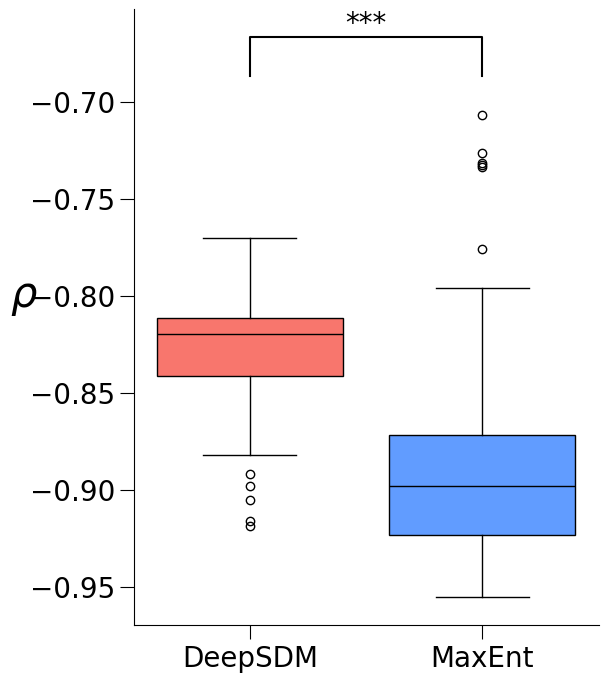

In [101]:
# 假设您已经加载了数据到 DataFrame df
df_spearman = pd.read_csv(os.path.join(plot_path_nichespace, 'spearman_info_basedonDeepSDMpred.csv'))

# 确保数据是按物种配对的
grouped_rho_values = df_spearman.pivot(index='species', columns='model', values='rho')
paired_rho_values = grouped_rho_values.dropna()  # 删除任何缺失值

# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm_max'], paired_rho_values['maxent_max'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm_max, paired_rho_values.maxent_max], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm_max), max(paired_rho_values.maxent_max)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path_nichecomparison, f'correlation_comparison_boxplot.pdf')
# plt.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

 - sum

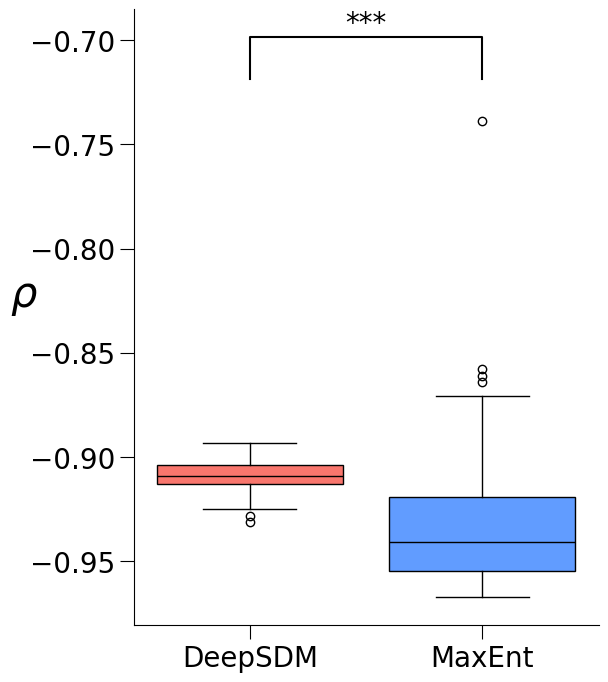

In [102]:
# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm_sum'], paired_rho_values['maxent_sum'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm_sum, paired_rho_values.maxent_sum], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm_sum), max(paired_rho_values.maxent_sum)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path_nichecomparison, f'correlation_comparison_boxplot.png')
# plt.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

 - mean

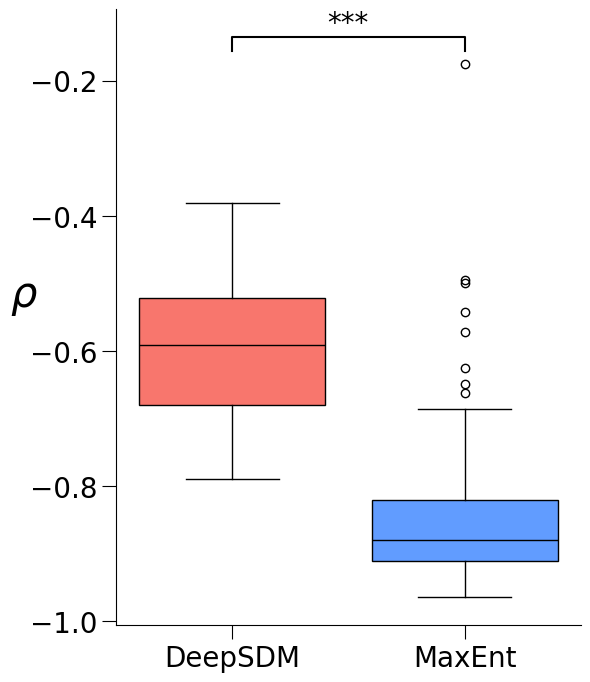

In [103]:
# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm_mean'], paired_rho_values['maxent_mean'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm_mean, paired_rho_values.maxent_mean], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm_mean), max(paired_rho_values.maxent_mean)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path_nichecomparison, f'correlation_comparison_boxplot.png')
# plt.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

### 比較（中心並沒有以模型預測值計算）
 - max

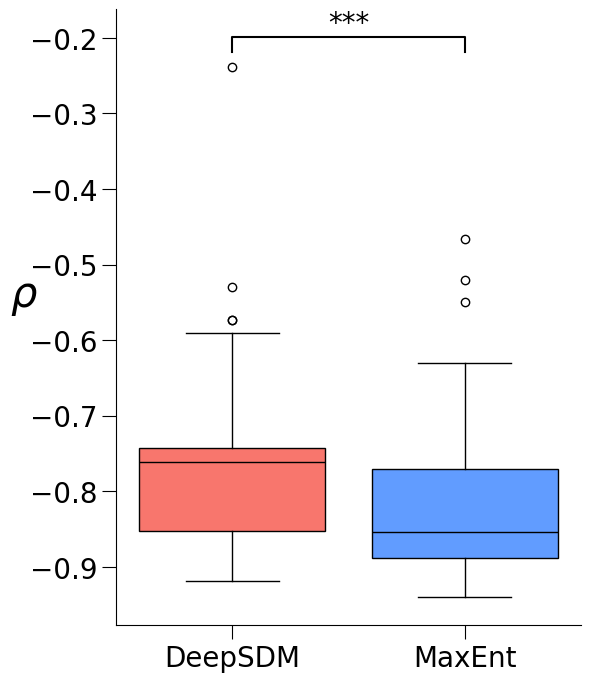

In [104]:
# 假设您已经加载了数据到 DataFrame df
df_spearman = pd.read_csv(os.path.join(plot_path_nichespace, 'spearman_info.csv'))

# 确保数据是按物种配对的
grouped_rho_values = df_spearman.pivot(index='species', columns='model', values='rho')
paired_rho_values = grouped_rho_values.dropna()  # 删除任何缺失值

# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm_max'], paired_rho_values['maxent_max'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm_max, paired_rho_values.maxent_max], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm_max), max(paired_rho_values.maxent_max)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path_nichecomparison, f'correlation_comparison_boxplot.png')
# plt.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

 - sum

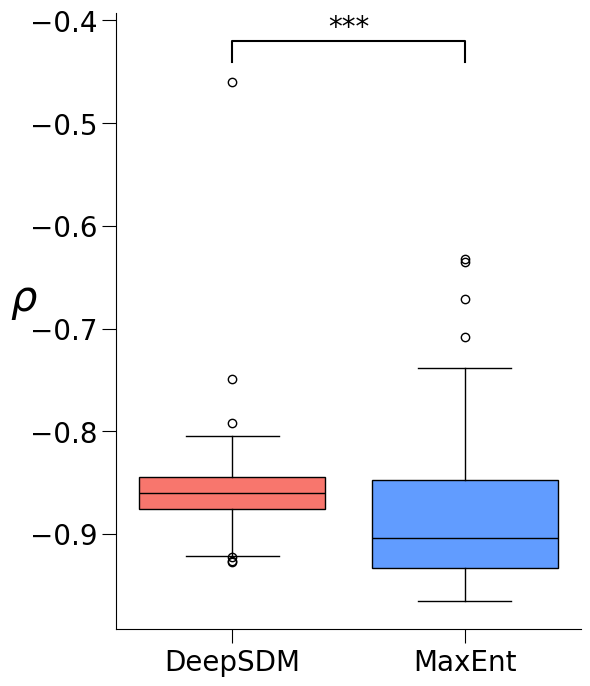

In [105]:
# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm_sum'], paired_rho_values['maxent_sum'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm_sum, paired_rho_values.maxent_sum], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm_sum), max(paired_rho_values.maxent_sum)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path_nichecomparison, f'correlation_comparison_boxplot.png')
# plt.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

 - mean

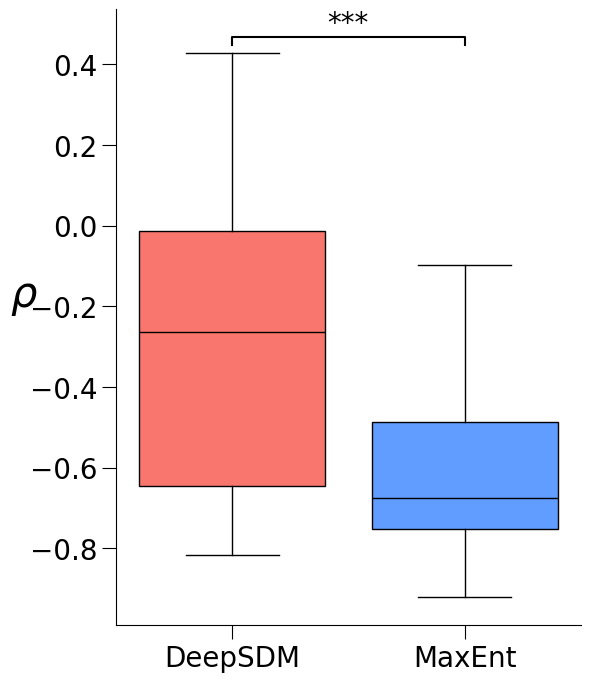

In [106]:
# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm_mean'], paired_rho_values['maxent_mean'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm_mean, paired_rho_values.maxent_mean], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm_mean), max(paired_rho_values.maxent_mean)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path_nichecomparison, f'correlation_comparison_boxplot.png')
# plt.savefig(path_out, dpi = 100, transparent = False, facecolor='white',  bbox_inches='tight')

In [166]:
df = feather.read_dataframe('plots/e52c8ac9a3e24c75ac871f63bbdea060/hypervolume/Ketupa_flavipes.feather')

In [167]:
df

,pc01_occ,pc02_occ,pc03_occ,pc01_maxent,pc02_maxent,pc03_maxent,pc01_deepsdm,pc02_deepsdm,pc03_deepsdm,date
0,-2.356691,0.685736,1.044630,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2009-10-01
1,2.277102,1.085373,1.266092,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2013-04-01
2,1.748315,-0.541710,0.650344,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2013-05-01
3,NaN,NaN,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2013-07-01
4,1.798861,1.289922,0.292193,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2015-12-01
5,NaN,NaN,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2016-04-01
6,-2.022219,1.631089,0.674439,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2017-01-01
7,1.847675,0.947111,-0.224100,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2018-12-01


### 計算niche相似度與共域次數的關聯

In [11]:
plot_path_nichespace_h5 = os.path.join(plot_path_nichespace, 'h5')

### euclidean 距離

In [8]:
coocc_counts = pd.read_csv('./workspace/species_data/cooccurrence_data/cooccurrence.csv', sep = '\t')
coocc_counts = coocc_counts[(coocc_counts.sp1.isin(species_list_predict)) & 
                            (coocc_counts.sp2.isin(species_list_predict)) & 
                            (coocc_counts.sp1 != coocc_counts.sp2) & 
                            (coocc_counts.counts != 0)].reset_index(drop = True)

In [13]:
# 预加载文件到内存
def preload_nichespace_files(coocc_counts):
    nichespace_cache = {}
    unique_species = set(coocc_counts['sp1']).union(set(coocc_counts['sp2']))
    
    for species in unique_species:
        with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
            for model, suffix in [('deepsdm', 'max'), ('maxent', 'max')]:
                rst = hf[f'{model}_all_season_{suffix}'][:]
                nichespace_cache[(species, model)] = rst[rst > 0]
    return nichespace_cache

In [14]:
# 初始化結果列表
coocc_counts_value = []
niche_deepsdm_euclidean_distance = []
niche_maxent_euclidean_distance = []
nichespace_cache = preload_nichespace_files(coocc_counts)
# 主迴圈
for _, data in coocc_counts.iterrows():

    # 檢查檔案是否存在
    if (data.sp1, 'maxent') not in nichespace_cache or (data.sp1, 'deepsdm') not in nichespace_cache or (data.sp2, 'maxent') not in nichespace_cache or (data.sp2, 'deepsdm') not in nichespace_cache:
        continue

    # 加載數據
    niche_space_deepsdm = [nichespace_cache[(species, 'deepsdm')] for species in [data.sp1, data.sp2]]
    niche_space_maxent = [nichespace_cache[(species, 'maxent')] for species in [data.sp1, data.sp2]]

    # 檢查是否有空陣列
    if any(space.size == 0 for space in niche_space_deepsdm + niche_space_maxent):
        continue

    # 計算歐幾里得距離
    niche_deepsdm_euclidean_distance.append(euclidean(*niche_space_deepsdm))
    niche_maxent_euclidean_distance.append(euclidean(*niche_space_maxent))
    coocc_counts_value.append(data.counts)

# 計算 Spearman 相關係數
rho_deepsdm, p_deepsdm = scipy.stats.spearmanr(
    np.array(niche_deepsdm_euclidean_distance), np.array(coocc_counts_value)
)
rho_maxent, p_maxent = scipy.stats.spearmanr(
    np.array(niche_maxent_euclidean_distance), np.array(coocc_counts_value)
)

# 輸出結果
print(f'rho of deepsdm: {rho_deepsdm}')
print(f'rho of maxent: {rho_maxent}')

rho of deepsdm: -0.41493596307550756
rho of maxent: -0.5699862389901439


Text(0.5, 1.0, 'DeepSDM (Euclidean distance)')

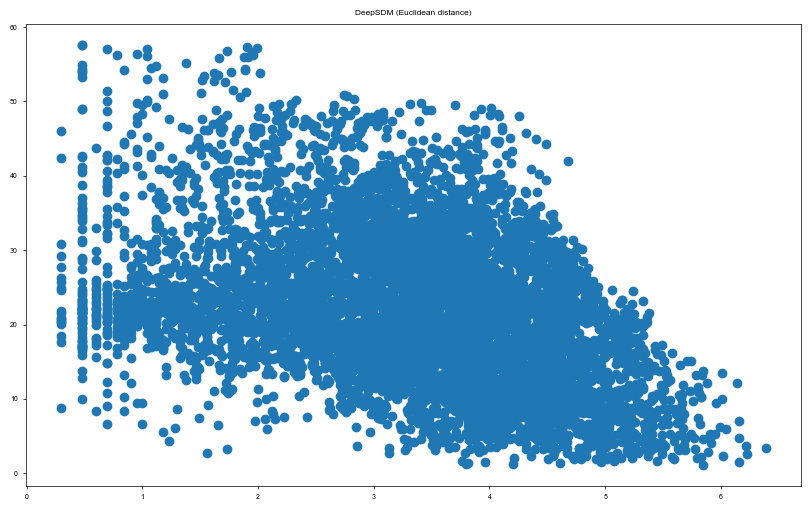

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(np.array(coocc_counts_value)+1), niche_deepsdm_euclidean_distance)
ax.set_title('DeepSDM (Euclidean distance)')

Text(0.5, 1.0, 'MaxEnt (Euclidean distance)')

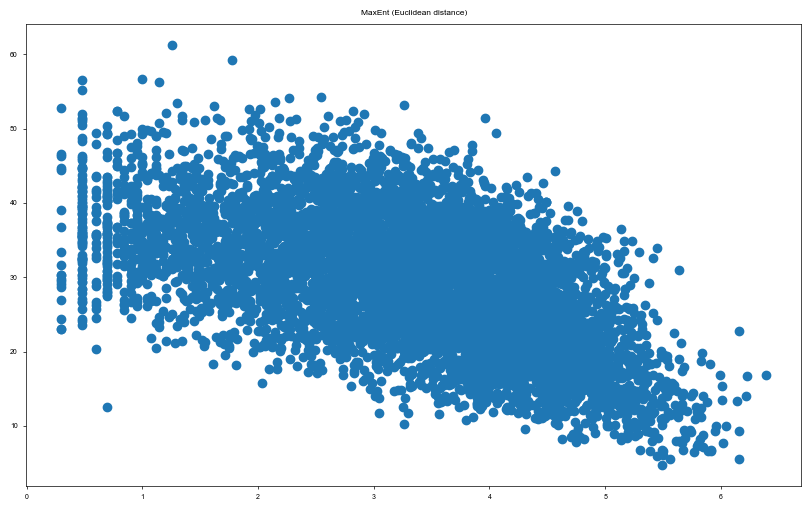

In [16]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(np.array(coocc_counts_value)+1), niche_maxent_euclidean_distance)
ax.set_title('MaxEnt (Euclidean distance)')

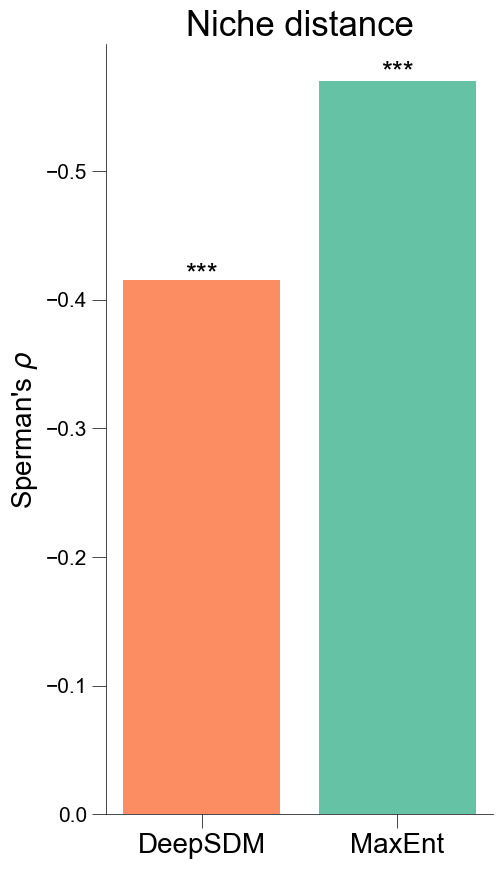

In [17]:
fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(['DeepSDM', 'MaxEnt'], [rho_deepsdm, rho_maxent], color = ['#fc8d62', '#66c2a5'])
ax.set_ylabel(rf"Sperman's $\rho$", size = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', which='both', labelsize=20, length = 10)
ax.tick_params(axis='y', which='both', labelsize=15, length = 10)
ax.set_title('Niche distance', size = 25)
ax.invert_yaxis()
ax.text(0, rho_deepsdm*1.01, get_significance_stars(p_deepsdm), ha = 'center', va = 'center', size = 20)
ax.text(1, rho_maxent*1.01, get_significance_stars(p_maxent), ha = 'center', va = 'center', size = 20)

path_out = os.path.join(plot_path_nichecomparison, 'rho_bar_euclidean_distance.pdf')
# plt.savefig(path_out, dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

### cosine similarity

In [18]:
from scipy.stats import spearmanr
from joblib import Parallel, delayed

# 手动计算 Cosine Similarity
def cosine_similarity_manual(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return dot_product / norm_product if norm_product != 0 else 0

# 处理单行数据
def process_row(data, nichespace_cache):
    try:
        # 获取缓存中的栖息空间数据
        niche_space_deepsdm = [nichespace_cache[(sp, 'deepsdm')] for sp in [data.sp1, data.sp2]]
        niche_space_maxent = [nichespace_cache[(sp, 'maxent')] for sp in [data.sp1, data.sp2]]
        # 检查是否有数据缺失

        if any(ns is None for ns in niche_space_deepsdm) or any(ns is None for ns in niche_space_maxent):
            return None

        # 计算 Cosine Similarity
        cosine_deepsdm = cosine_similarity_manual(niche_space_deepsdm[0], niche_space_deepsdm[1])
        cosine_maxent = cosine_similarity_manual(niche_space_maxent[0], niche_space_maxent[1])
        
        return data.counts, cosine_deepsdm, cosine_maxent
    except Exception as e:
        return None

# 预加载栖息空间文件
print("Preloading nichespace files...")
nichespace_cache = preload_nichespace_files(coocc_counts)
#     print(nichespace_cache)
# 并行处理每一行数据
print("Processing co-occurrence data...")

results = Parallel(n_jobs=-1)(
    delayed(process_row)(data, nichespace_cache) for _, data in coocc_counts.iterrows()
)
# 收集结果
valid_results = [r for r in results if r is not None]

# 检查 valid_results 是否为空
if not valid_results:
    print("No valid results were returned. Please check the input data or processing logic.")
else:
    # 解包结果
    counts, deepsdm_cosine, maxent_cosine = zip(*valid_results)

    # 计算 Spearman 相关系数
    rho_cosine_deepsdm, p_cosine_deepsdm = spearmanr(np.array(deepsdm_cosine), np.array(counts))
    rho_cosine_maxent, p_cosine_maxent = spearmanr(np.array(maxent_cosine), np.array(counts))

    # 输出结果
    print(f'rho of deepsdm: {rho_cosine_deepsdm}, p-value: {p_cosine_deepsdm}')
    print(f'rho of maxent: {rho_cosine_maxent}, p-value: {p_cosine_maxent}')

Preloading nichespace files...
Processing co-occurrence data...
rho of deepsdm: 0.7086817340018878, p-value: 0.0
rho of maxent: 0.5629972423746227, p-value: 0.0


Text(0.5, 1.0, 'DeepSDM (Cosine similarity)')

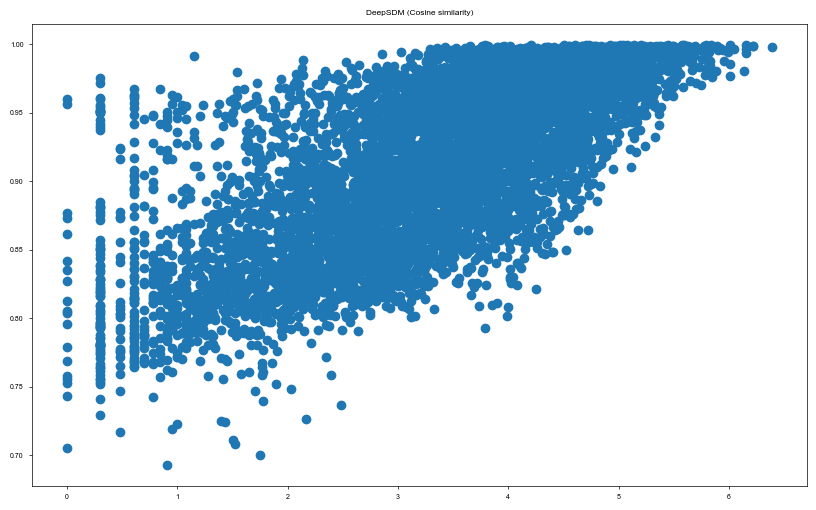

In [19]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(np.array(counts)), np.array(deepsdm_cosine))
ax.set_title('DeepSDM (Cosine similarity)')

Text(0.5, 1.0, 'MaxEnt (Cosine similarity)')

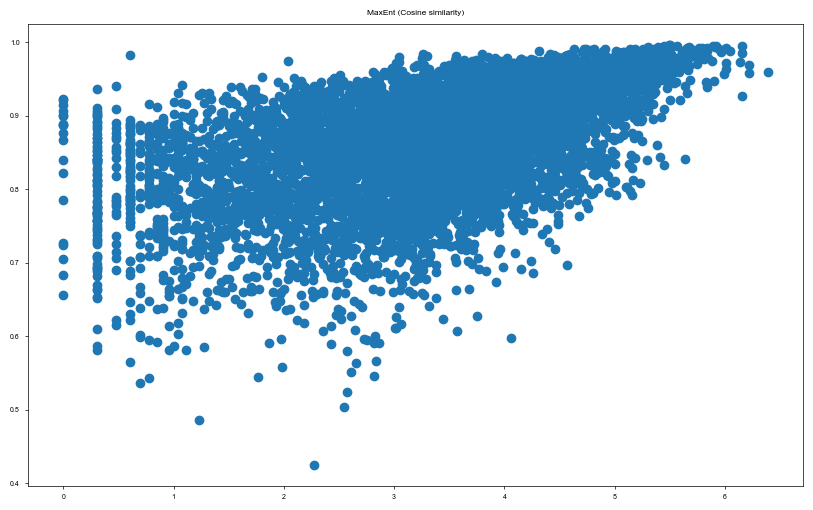

In [20]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(np.array(counts)), np.array(maxent_cosine))
ax.set_title('MaxEnt (Cosine similarity)')

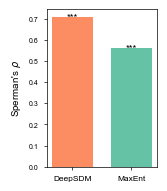

In [40]:
fig, ax = plt.subplots(figsize = mm2inch(40, 50), gridspec_kw = {'left': 0.25, 'right': 0.95, 
                                                               'bottom': 0.15, 'top': 0.95})
ax.bar(['DeepSDM', 'MaxEnt'], [rho_cosine_deepsdm, rho_cosine_maxent], color = ['#fc8d62', '#66c2a5'], width = 0.7)
ax.set_ylabel(rf"Sperman's $\rho$")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.text(0, rho_cosine_deepsdm, get_significance_stars(p_cosine_deepsdm), ha = 'center', va = 'center', size = 7)
ax.text(1, rho_cosine_maxent, get_significance_stars(p_cosine_maxent), ha = 'center', va = 'center', size = 7)

ax.tick_params('x', labelsize = 6)
path_out = os.path.join(plot_path_nichecomparison, 'rho_bar_cosine_similarity.pdf')
plt.savefig(path_out, dpi = 500, transparent = True)
plt.show()